## Connection to Thymio

In [1]:
# Connect to Thymio with ClientAsync
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()

# Lock Thymio
aw(node.lock())

Node fe36b4a4-2452-4ab5-8d68-b28bb42f53d5

## Importation of libraries

In [2]:
import keyboard
import time
from kalman_filtering.kalman_filter import *
from thymio.control import *
from computer_vision.vision import *
from path_planning.path_plan import *
from navigation.collision_avoidance import *

[[3 3]
 [4 4]
 [5 5]]


## Main script

In [ ]:
map = Map()
if P_VISION:
    print(P_SETUP)
    print("Place the Thymio and the destination, check that everything is properly set. Then, press S.")

# Call a first single update step to create our vision windows
map.update(True) 

while True:
    
    if keyboard.is_pressed('space'):
        map.update(True)
    
    if keyboard.is_pressed('s'):
        if map.found_corners and map.found_destination:
            map.update()
            break
        else:
            print("USER: Must find corners before start")
    
    cv.waitKey(10)

if P_VISION: print(P_START)
if P_VISION: map.info()
await node.wait_for_variables()

vel_old = np.zeros(2)
mu_est_old = np.array([map.robot[0], map.robot[1], map.robot[2]])
cov_est_old = 100*np.eye(3)
view_blocked = False
active = True
end = False
start = True
path = None
segment_index = 0
avoidance_mode = 0
obj_right = False
obstacle_pos = np.array([0, 0])
destination = map.destination[0:2]
pos_robot = map.robot[0:2]
dt = 0.12

while active == True:
    start_time = time.time()
    print("----------------------")
    active = await stop_thymio(node)

    map.update()
    
    # State variables measurement
    await node.wait_for_variables()
 
    # Filtering
    x_est, cov_est = kalman_filter(vel_old, mu_est_old, cov_est_old, map.found_robot, dt)
    map.pose_est = np.array([int(x_est[0]), int(x_est[1]), x_est[2]], dtype=object)
    cov_est_old = cov_est
    mu_est_old = x_est

    # Check if final destination moved
    change_dest = ((map.destination[1]-destination[1])**2 + (map.destination[0]-destination[0])**2)*0.5
    if change_dest > 20:
        start = True
        print("Nouveau chemin destination changé")

    #  Check if the robot has been relocated
    change_robot = ((map.pose_est[1]-pos_robot[1])**2 + (map.pose_est[0]-pos_robot[0])**2)*0.5
    if change_robot > 200:
        start = True
        print("Nouveau chemin robot changé")
   
    # Global Navigation
    if start == True:
        destination = map.destination[0:2]
        ex_path, corners = compute_visibility_matrix(map.pose_est[0:2], destination, map.obstacles)
        map.obstacles_lines = possible_lignes(ex_path, corners)
        map.target_lines = a_star_search(corners, ex_path)
        path = path_functions(map.target_lines)
        segment_index = 0
        start = False

    #local nav
    u, avoidance_mode, segment_index, obj_right, obstacle_pos = await collision_avoidance(path, node, map.pose_est, avoidance_mode, segment_index, obj_right, obstacle_pos, map.destination[0:2]) # Zacharie
    #print("avoidance_mode", avoidance_mode)

    if not avoidance_mode:
        u, segment_index, end = path_direction(map.pose_est, path, segment_index)
    
    #update robot position            
    pos_robot = map.pose_est[0:2]

    await node.set_variables(motors(int(u[0]), int(u[1])))

    vel_old = u
    
    end_time = time.time()
    # Update execution time
    dt = end_time - start_time
    #print("Execution time:", dt)  
    cv.waitKey(10)
    if keyboard.is_pressed('q'):
        map.__del__()
        break

Prediction covariances: 0.012656025204928121 0.003118662799949187 1.053713019390582e-06
distance_to_obstacle 656.8964910851632
Prediction covariances: 0.46613930887459026 0.12471140131068212 3.946747381919047e-05
distance_to_obstacle 653.7927806270118
Prediction covariances: 0.011123424969190068 0.0033038460076952663 9.637086488125568e-07
distance_to_obstacle 653.7927806270118
Prediction covariances: 0.01142831203668863 0.0037090986946148167 1.0111443574988925e-06
distance_to_obstacle 653.7927806270118
Prediction covariances: 0.011570015679470988 0.003061188373600159 9.773309110972321e-07
distance_to_obstacle 653.7927806270118
Prediction covariances: 0.011329419189203148 0.0036769949218702917 1.0023940833768403e-06
distance_to_obstacle 653.7927806270118
Prediction covariances: 0.011470450083072996 0.003196695180225625 9.797317016001972e-07
distance_to_obstacle 653.3008495325871
Prediction covariances: 0.010811130899866685 0.0038479161937928024 9.791907624209657e-07
distance_to_obstacle

## Thymio velocity measurements

In [ ]:
from thymio.control import *
import matplotlib.pyplot as plt

active = True
v_l = []
v_r = []

while active:
    await node.wait_for_variables()
    await node.set_variables(motors(100, 100))
    v = get_thymio_velocity(node)
    v_l.append(v[0])
    v_r.append(v[1])
    active = await stop_thymio(node)

await node.set_variables(motors(0, 0)) 

v_l_mean = np.mean(v_l[10:])
v_l_var = np.var(v_l[10:])

v_r_mean = np.mean(v_r[10:])
v_r_var = np.var(v_r[10:])

print("Left vel measured:", v_l[10:])
print("Left vel mean:", v_l_mean)
print("Left vel variance:", v_l_var)

nb_iteration = np.linspace(0, len(v_l[10:]), len(v_l[10:]))
plt.plot(nb_iteration, v_l[10:])
plt.title("Left motor velocity covariance in measurement")
plt.show()

print("Right vel measured:", v_r[10:])
print("Right vel mean:", v_r_mean)
print("Right vel variance:", v_r_var)

nb_iteration = np.linspace(0, len(v_r[10:]), len(v_r[10:]))
plt.plot(nb_iteration, v_r[10:])
plt.title("Right motor velocity covariance in measurement")
plt.show()

## Thymio position measurements

0.010998964309692383
0.006993293762207031
0.009005308151245117
0.008995294570922852
0.004998922348022461
0.006797075271606445
0.006997823715209961
0.013006925582885742
0.005005359649658203
0.005997657775878906
0.005996227264404297
0.00699925422668457
0.0071642398834228516
0.010003805160522461
0.0050013065338134766
0.005001544952392578
0.005003690719604492
0.004980802536010742
0.005000591278076172
0.02338552474975586
0.00895833969116211
0.011510133743286133
0.0060002803802490234
0.00600123405456543
0.006000995635986328
0.004999637603759766
0.005994558334350586
0.005506992340087891
0.006999969482421875
0.010004281997680664
0.010914087295532227
0.01500844955444336
0.005003452301025391
0.0050046443939208984
0.005004167556762695
0.007370948791503906
0.008513450622558594
0.009663820266723633
0.004999637603759766
0.004581928253173828
0.0050029754638671875
0.0050051212310791016
0.0060007572174072266
0.023812294006347656
0.011995792388916016
0.006994485855102539
0.0050013065338134766
0.00599193

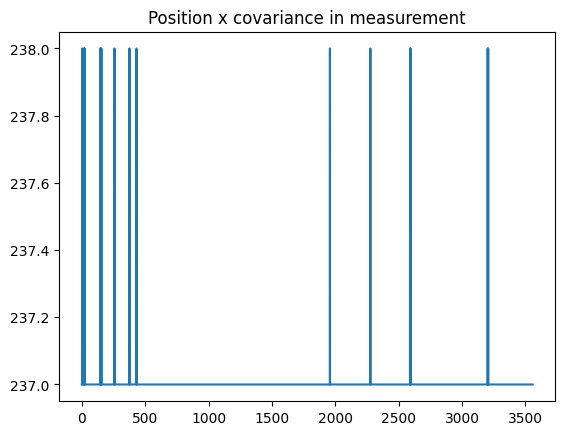

Position y measured: [340, 340, 340, 340, 340, 340, 339, 340, 340, 339, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 340, 339, 340, 340, 339, 340, 340, 340, 340, 340, 340, 340

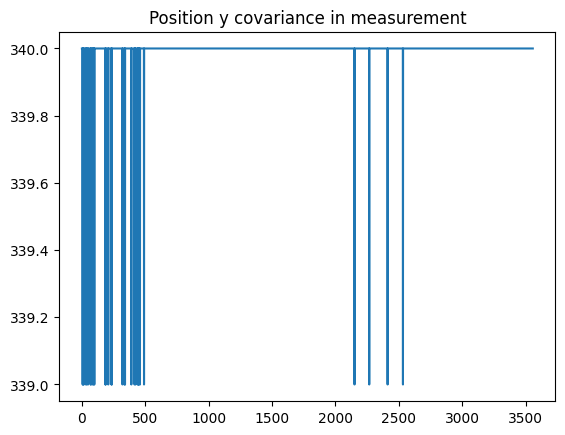

Position theta measured: [-1.573065254822489, -1.556833692778942, -1.573065254822489, -1.5233233711406509, -1.556833692778942, -1.573065254822489, -1.5329226820266195, -1.556833692778942, -1.573065254822489, -1.5439182563141838, -1.573065254822489, -1.5791739072044695, -1.5392058673337992, -1.5791739072044695, -1.573065254822489, -1.5329226820266195, -1.5791739072044695, -1.573065254822489, -1.5357152088298105, -1.5392058673337992, -1.558404489105737, -1.5791739072044695, -1.5392058673337992, -1.558404489105737, -1.556833692778942, -1.573065254822489, -1.573065254822489, -1.573065254822489, -1.573065254822489, -1.556833692778942, -1.5392058673337992, -1.5439182563141838, -1.556833692778942, -1.573065254822489, -1.573065254822489, -1.573065254822489, -1.573065254822489, -1.556833692778942, -1.573065254822489, -1.5439182563141838, -1.5392058673337992, -1.573065254822489, -1.5791739072044695, -1.5392058673337992, -1.573065254822489, -1.5392058673337992, -1.573065254822489, -1.539205867333

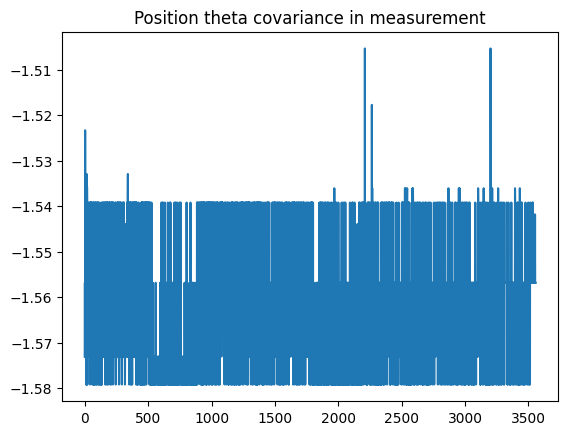

In [3]:
import matplotlib.pyplot as plt

map = Map()

robot_positions_x = []
robot_positions_y = []
robot_positions_theta = []
map.update(True)
while True:
    start = time.time()
    map.update()
    robot_position_x = map.robot[0]
    robot_positions_x.append(robot_position_x)

    robot_position_y = map.robot[1]
    robot_positions_y.append(robot_position_y)
    
    robot_position_theta = map.robot[2] 
    robot_positions_theta.append(robot_position_theta)
    end = time.time()
    dt = end - start
    print(dt)

    if cv.waitKey(20) & 0xFF==ord("d"):
        map.__del__()
        break

robot_positions_x_mean = np.mean(robot_positions_x[10:])
robot_positions_x_var = np.var(robot_positions_x[10:])

robot_positions_y_mean = np.mean(robot_positions_y[10:])
robot_positions_y_var = np.var(robot_positions_y[10:])

robot_positions_theta_mean = np.mean(robot_positions_theta[10:])
robot_positions_theta_var = np.var(robot_positions_theta[10:])

print("Position x measured:", robot_positions_x[10:])
print("Position x mean:", robot_positions_x_mean)
print("Position x variance:", robot_positions_x_var)

nb_iteration = np.linspace(0, len(robot_positions_x[10:]), len(robot_positions_x[10:]))
plt.plot(nb_iteration, robot_positions_x[10:])
plt.title("Position x covariance in measurement")
plt.show()

print("Position y measured:", robot_positions_y[10:])
print("Position y mean:", robot_positions_y_mean)
print("Position y variance:", robot_positions_y_var)

plt.plot(nb_iteration, robot_positions_y[10:])
plt.title("Position y covariance in measurement")
plt.show()

print("Position theta measured:", robot_positions_theta[10:])
print("Position theta mean:", robot_positions_theta_mean)
print("Position theta variance:", robot_positions_theta_var)

plt.plot(nb_iteration, robot_positions_theta[10:])
plt.title("Position theta covariance in measurement")
plt.show()

In [ ]:
node.var

{'_fwversion': [14, 0],
 '_id': [-27410],
 '_imot': [-162, -184],
 '_integrator': [-1079, -1177],
 '_productId': [8],
 '_vbat': [690, 688],
 'acc': [3, 0, 21],
 'acc._tap': [32],
 'button.backward': [0],
 'button.center': [1],
 'button.forward': [0],
 'button.left': [0],
 'button.right': [0],
 'buttons._mean': [10674, 9159, 13755, 13702, 15106],
 'buttons._noise': [58, 40, 62, 60, 57],
 'buttons._raw': [10658, 9157, 12878, 13710, 15109],
 'event.args': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'event.source': [-27410],
 'leds.bottom.left': [0, 0, 0],
 'leds.bottom.right': [0, 0, 0],
 'leds.circle': [0, 0, 0, 0, 0, 0, 0, 0],
 'leds.top': [0, 0, 0],
 'mic._mean': [283],
 'mic.intensity': [65],
 'mic.threshold': [0],
 'motor.left.pwm': [-421],
 'motor.left.speed': [89],
 'motor.left.target': [100],
 'motor.right.pwm': [-438],
 'motor.right.speed': [82],
 'motor.right.targ